# Time series Analysis using ARIMA, SARIMA, Auto ARIMA

In [22]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from math import sqrt
import statsmodels.api as sm
import itertools
from prettytable import PrettyTable
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
plt.style.use('fivethirtyeight')
rcParams['text.color'] = 'k'

#### Preprocessing

In [4]:
data = pd.read_csv('/home/prodigalson/J Files/Project - Time Series/data.csv',sep=';')

In [5]:
data['DOR'] = pd.to_datetime(data['DOR'])
data.head()

,Name,Sex,Age,Area,DOR
0,UNNIKRISHNAN,M,17.0,CORPORATION,2013-01-01
1,MURAMMIL,M,6.0,ANDOORKONAM,2013-01-01
2,RAJAMMA,F,50.0,BALARAMAPURAM,2013-01-01
3,ANJU,F,15.0,CORPORATION,2013-01-01
4,THANKAMANI,F,43.0,POOZHANAD,2013-01-01


This step includes removing columns we do not need, aggregate count by month and Indexing with Time Series Data.

In [6]:
data['MnthWse'] = data['DOR'].map(lambda x: x.strftime('%Y-%m'))
sumry = pd.DataFrame(data.MnthWse.value_counts().sort_index()).reset_index()
sumry.columns = ['MnthWse', 'Cnt']
# sumry['MnthWse'] = pd.to_datetime(sumry['MnthWse'], format='%Y-%m')
# sumry['MnthWse'] = sumry['MnthWse'].map(lambda x: x.strftime('%Y-%m'))
sumry['MnthWse'] = pd.to_datetime(sumry.MnthWse)
sumry = sumry.set_index(sumry.MnthWse)
sumry.drop('MnthWse', axis = 1, inplace = True)

In [7]:
sumry.head()

,Cnt
MnthWse,
2013-01-01,224
2013-02-01,217
2013-03-01,238
2013-04-01,324
2013-05-01,456


In [8]:
sumry.dtypes

Cnt    int64
dtype: object

In [9]:
# TimeSeries Data
ts = sumry['Cnt']
ts

MnthWse
2013-01-01    224
2013-02-01    217
2013-03-01    238
2013-04-01    324
2013-05-01    456
             ... 
2018-08-01     27
2018-09-01     24
2018-10-01     23
2018-11-01     32
2018-12-01     29
Name: Cnt, Length: 72, dtype: int64

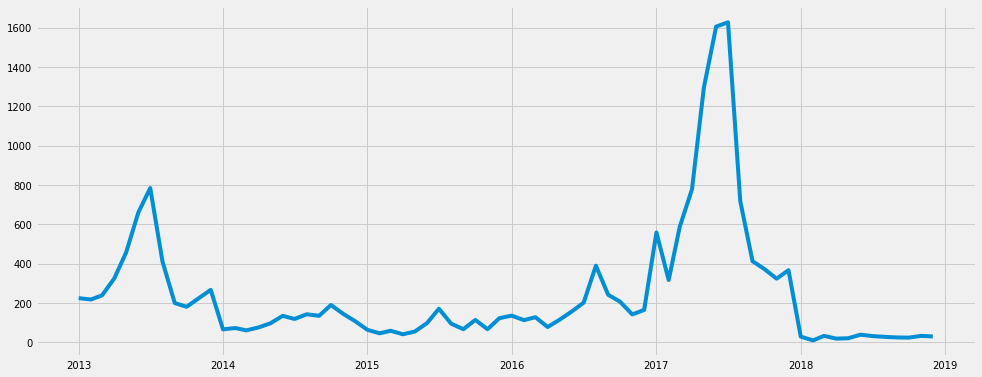

In [10]:
plt.plot(ts)

The most reported cases are in 2017 with nearly 9000 cases more than double the cases reported in 2013

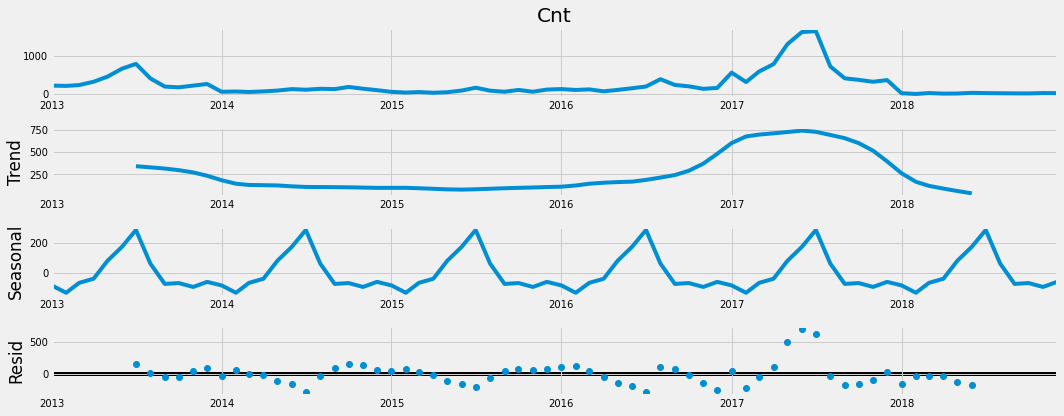

In [11]:
"""
Time-series decomposition allows us to decompose our time series into three distinct 
components: trend, seasonality, and noise/residual.
"""

decomposition = sm.tsa.seasonal_decompose(ts, model='additive')
fig = decomposition.plot()
plt.show()

There is no observable trend in the data. 
We can clearly observe seasonality in the above graph, there is an increase in the dengue cases during mid months of the year as the spread of dengue is usually associated with heat and the rainy season, since the Aedes mosquito often comes in contact with humans after breeding in exposed still water.

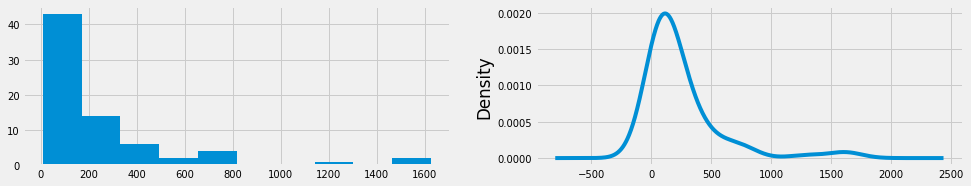

In [12]:
plt.subplot(221)
plt.hist(ts)
plt.subplot(222)
ts.plot(kind = 'kde')

Most of the monthly cases hover around 0-200 and monthly cases above 800 are rare. Kernel density estimation shows the continuous version of a histogram estimated from the data.

### ARIMA

- One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for Auto Regressive Integrated Moving Average. ARIMA is a model that can be fitted to time series data to predict future points in the series.

- Most time series models require the data to be stationary. A time series is said to be stationary if its statistical properties such as mean, variance & covariance remain constant over time.

- In order to check the time series stationarity we can either use time series decomposition method which we used above to decompose the series into trend, seasonality, residual or we can use the statical technique Augmented Dicky Fuller Test.

- If the time series is not stationary we have to remove trend & seasonality using differencing. We can also use another techniques like taking log or nth root etc.The number of differencing done to make the time series stationary is the d value. The AR & MA (p & q) can be obtained from the PACF & ACF plots

A quick and dirty way to check to see if your time series is non-stationary is to review summary statistics. Just split the time series into two partitions and compare the mean and variance of each group. If the difference is statistically significant, the time series is likely non-stationary.

In [13]:
X = ts.values
split = int(len(X) / 3)
G1, G2, G3 = X[0:split], X[split:(2*split)],X[(2*split):] 
val = [["Mean", G1.mean(), G2.mean(), G3.mean()], ["Varience", G1.var(), G2.var(),G3.var()]]
table = PrettyTable(['','G1', 'G2', 'G3'])
for row in val:
    table.add_row(row)
print(table)

+----------+--------------------+-------------------+--------------------+
|          |         G1         |         G2        |         G3         |
+----------+--------------------+-------------------+--------------------+
|   Mean   | 229.91666666666666 |      127.125      | 386.1666666666667  |
| Varience | 32299.40972222223  | 5779.192708333333 | 239704.72222222222 |
+----------+--------------------+-------------------+--------------------+


Here the mean & variance of the three groups differ by significant values. So there there is possibility that the series is non-stationary. In order to confirm this we have to perform some statistical tests like ADF or KPSS

In [14]:
# #define function for kpss test
# from statsmodels.tsa.stattools import kpss
# #define KPSS
# def kpss_test(ts):
#     print ('Results of KPSS Test:')
#     kpsstest = kpss(ts, regression='c')
#     kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
#     for key,value in kpsstest[3].items():
#         kpss_output['Critical Value (%s)'%key] = value
#     print(kpss_output)

In [15]:
# kpss_test(ts)

In [16]:
def test_stationarity(ts):
    
    #Determing rolling statistics
    rolmean = ts.rolling(window=12,center=True).mean() 
    rolstd = ts.rolling(window=12,center=True).std()

    #Plot rolling statistics:
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

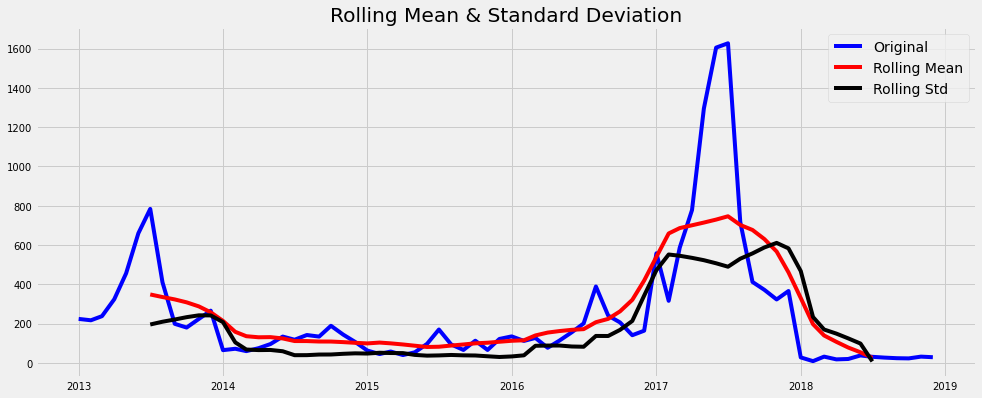

Results of Dickey-Fuller Test:
Test Statistic                 -3.053529
p-value                         0.030189
#Lags Used                      1.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64


In [17]:
test_stationarity(ts)

Here p-value < 0.05 & test statistic < critical value at 5% so, time series is stationary with more than 95% certainty. These results contradicts the results obtained by comparing mean & variance. It happened because the 2nd group had more number of cases (2017 had almost 1600 cases). 
                            But as we can see from the graph mean and standard deviation have variatons in the begining & towards the end. We also need to remove seasonality as we observed the same in time series decomposition. So it is better to apply a transformation which penalizesthe higher values like taking a log, square root, cube root, etc. and differencing to remove seasonality.


In [18]:
ts_log = np.log(ts)
ts_log_diff = ts_log - ts_log.shift()

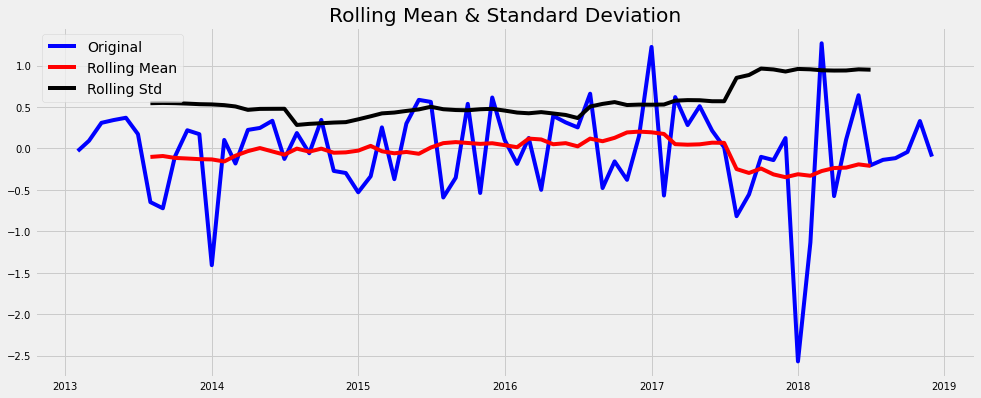

Results of Dickey-Fuller Test:
Test Statistic                -8.182654e+00
p-value                        8.053454e-13
#Lags Used                     0.000000e+00
Number of Observations Used    7.000000e+01
Critical Value (1%)           -3.527426e+00
Critical Value (5%)           -2.903811e+00
Critical Value (10%)          -2.589320e+00
dtype: float64


In [19]:
ts_log_diff.dropna(inplace = True)
test_stationarity(ts_log_diff)

The rolling values appear to be varying slightly. Also, the test statistic is smaller than the 1% critical values so we can say with 99% confidence that this is a stationary series. 

###### As we can  see checking wheather the series is stationary or not & if not, making it stationary involves a lot of steps and different approches. There is a way to skip the steps after data preprocessing & directly fit the model.

### SARIMAX

Here we are using Auto ARIMA model so that we can skip the stationary checking part and directly fit our model. We uses the AIC (Akaike Information Criterion) values generated by trying different combinations of p,q & d values to fit the model. This process is known as grid search for model selectiom

In [20]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
result = []

In [23]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            result.append([param, param_seasonal, results.aic])
            print(f"ARIMA{param}x{param_seasonal}12 - AIC:{results.aic}")
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1057.288439421006
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:879.8481927537298
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:910.3811019005491
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:702.8267709521069
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:892.4665003547077
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:875.8921703151271
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:724.6380028559672
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:700.8889888712067
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:981.3424675597735
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:817.5651335951549
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:851.110154577517
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:654.0591839863062
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:843.0031429296606
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:818.9011954922335
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:685.2761262108279
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:660.2334455735021
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:923.7936988947077
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:769.0459457538828
ARIMA(0, 1,

In [24]:
resultDF = pd.DataFrame(result,columns=['pdq','pdqs','aic'])
resultDF.loc[resultDF['aic'].idxmin()]

pdq         (0, 1, 1)
pdqs    (1, 1, 1, 12)
aic            609.03
Name: 31, dtype: object

The above output suggests that SARIMAX(0, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 2609.03. So we should consider this to be optimal option.

In [25]:
mod = sm.tsa.statespace.SARIMAX(ts,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1836      0.152      1.207      0.227      -0.114       0.482
ar.S.L12      -0.4002      0.196     -2.047      0.041      -0.783      -0.017
ma.S.L12      -1.0013      0.147     -6.796      0.000      -1.290      -0.713
sigma2      2.637e+04   5.57e-06   4.74e+09      0.000    2.64e+04    2.64e+04


The coef column shows the importance of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. 

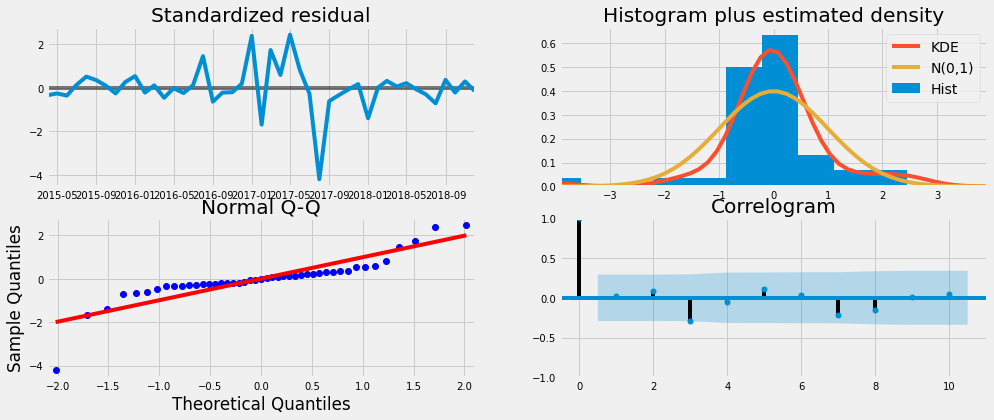

In [26]:
results.plot_diagnostics()
plt.show()

The residuals of the model should be uncorrelated and normally distributed with zero-mean. In this case, our model diagnostics shows that the model residuals are near normally distributed it's not perfect

In [27]:
pred = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()

In one-step ahead forecasts,the forecasts at each point are generated using the full history up to that point.

In [28]:
def pred_plot(start='2013',label='One-step ahead Forecast', mode= pred_ci):
    ax = ts[start:].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label=label, alpha=.7)

    ax.fill_between(mode.index,
                    mode.iloc[:, 0],
                    mode.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Reported Cases')
    plt.legend()

    plt.show()

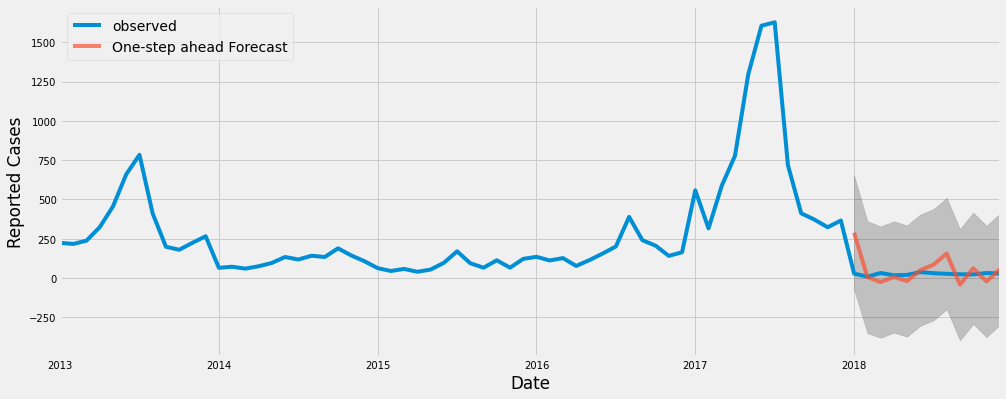

In [29]:
pred_plot()

In [30]:
# Compute the RMSE
def rmse(mode, date, pred_type):
    ts_forecasted = mode.predicted_mean
    ts_truth = ts[date:]
    print(f"The Root Mean Squared Error of {pred_type} forecast is {sqrt(mean_squared_error(ts_forecasted, ts_truth))}")

In [31]:
rmse(mode=pred, date='2018-01-01',pred_type='one-step ahead')

The Root Mean Squared Error of one-step ahead forecast is 92.17068115071696


In [32]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In dynamic forcast, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

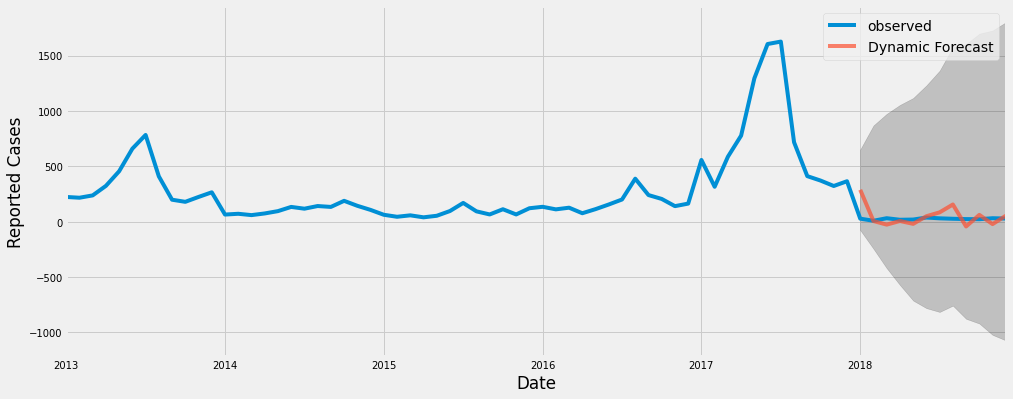

In [33]:
pred_plot(start='2013',label='Dynamic Forecast',mode=pred_dynamic_ci)

In [34]:
rmse(mode=pred_dynamic, date='2018-01-01',pred_type='dynamic')

The Root Mean Squared Error of dynamic forecast is 290.21716831926733


RMSE value from dynamic forecast is higher than one-step ahead forecast , which is to be expected given that we are relying on less historical data from the time series.

RMSE shows that the model was able to forecast the average monthly dengue cases in the test set within 92 of the real cases.

In [35]:
def forecast_plot(steps=12):
    pred_uc = results.get_forecast(steps=36)
    pred_ci = pred_uc.conf_int()

    ax = ts.plot(label='observed', figsize=(14, 7))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Reported Cases')

    plt.legend()
    plt.show()

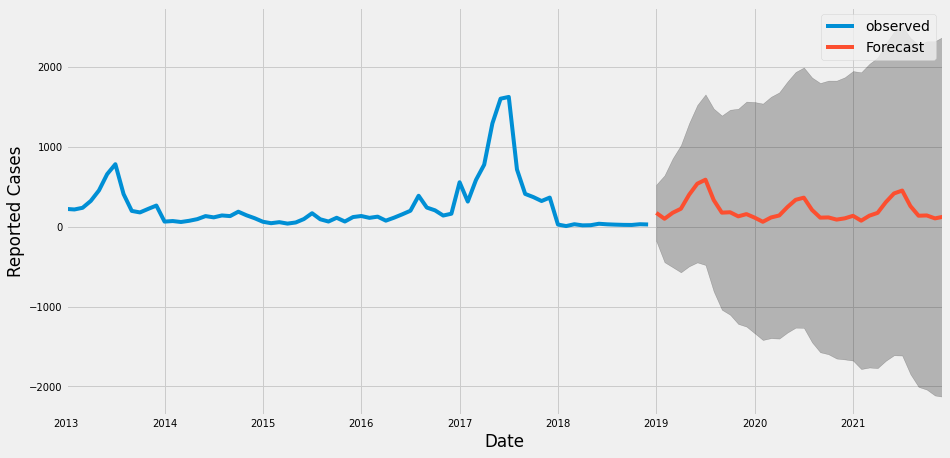

In [36]:
forecast_plot(steps=36)

The model clearly captured seasonality. As we further forecast the future, confidence intervals of the model grow larger since it is natural for us to become less confident in our values.

## Auto ARIMA

In Auto ARIMA we can change different parameters. [Click here](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html) to see the documentation

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=945.330, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1071.449, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=948.645, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1007.755, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=946.404, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=943.267, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=975.984, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=945.260, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=945.222, Time=0.17 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=949.603, Time=0.32 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=945.916, Time=0.33 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=940.258, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=958.017, Time=0.32 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=944.103, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=941

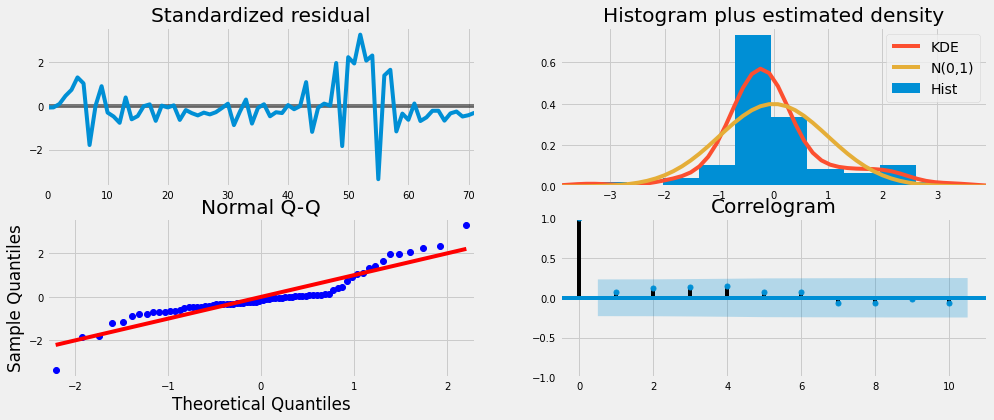

In [37]:
model = pm.auto_arima(ts, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,
                      d=0,
                      seasonal=True,
                      start_P=0, start_Q=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      supress_warnings=True,
                      stepwise=True, with_intercept=False)
print(model.summary())
model.plot_diagnostics()
plt.show()